# 의료 이미지 분류기
- auto encoder 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from PIL import Image

import wandb

import torch
import torchvision
import torchvision.transforms as T
from torchsummary import summary

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

# Data 확인

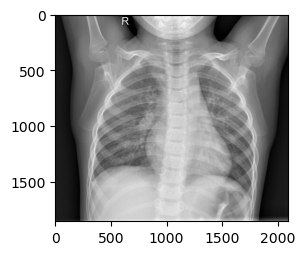

In [3]:
root_dir = './train'

img_test = Image.open(os.path.join(root_dir, 'NORMAL/IM-0115-0001.jpeg'))
plt.figure(figsize=(3, 3))
plt.imshow(img_test, cmap='gray')

# Custom Dataset

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, classes, transforms):
        super().__init__()
        self.data = list()
        self.transforms = transforms

        for label, cls in enumerate(classes):
            img_dir = os.path.join(root_dir, cls)
            img_list = os.listdir(img_dir)
            for img in img_list:
                self.data.append((os.path.join(img_dir, img), label))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.transforms(Image.open(self.data[idx][0]).convert('L'))
        label = self.data[idx][1]

        return img, label

In [5]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
])

train_dataset = CustomDataset('./train', ['NORMAL', 'PNEUMONIA'], transforms)
test_dataset = CustomDataset('./test', ['NORMAL', 'PNEUMONIA'], transforms)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


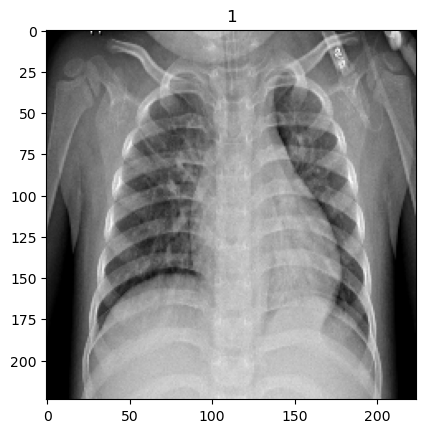

In [6]:
#plt.figure(figsize=(3, 3))
plt.imshow(np.array(train_dataset[5000][0].squeeze()), cmap='gray')
plt.title(train_dataset[5000][1])
plt.show()

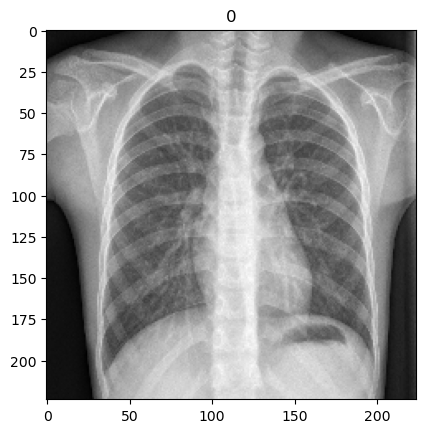

In [7]:
plt.imshow(np.array(test_dataset[0][0].squeeze()), cmap='gray')
plt.title(test_dataset[0][1])
plt.show()

In [8]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
np.array(train_dataset[1][0]).shape

(1, 224, 224)

# AutoEncoder Model

In [10]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=224*224, out_features=1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=1024, out_features=512),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=512, out_features=128),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=128, out_features=32)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=32, out_features=128),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=128, out_features=512),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=512, out_features=1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=1024, out_features=224*224),
        )

    def forward(self, x):
        x = x.view(-1, 224*224)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [11]:
train_dataset[0][0].view(train_dataset[0][0].size(0), -1).shape

torch.Size([1, 50176])

# train 함수

In [12]:
def training(model, train_dataloader, criterion, optimizer):
    model.train()

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        y = images.view(-1, 224*224)
        encoded, decoded = model(images)
        
        loss = criterion(decoded, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return model

def training_loop(model, train_dataloader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model = training(model, train_dataloader, criterion, optimizer)

    return model

In [13]:
autoencoder_model = Autoencoder()
summary(autoencoder_model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]      51,381,248
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 128]          65,664
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 32]           4,128
            Linear-8                  [-1, 128]           4,224
              ReLU-9                  [-1, 128]               0
           Linear-10                  [-1, 512]          66,048
             ReLU-11                  [-1, 512]               0
           Linear-12                 [-1, 1024]         525,312
             ReLU-13                 [-1, 1024]               0
           Linear-14                [-1

In [14]:
autoencoder_model = Autoencoder()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

autoencoder_model = training_loop(autoencoder_model, train_dataloader, criterion, optimizer, 1)

  0%|          | 0/164 [00:00<?, ?it/s]

# Test
- test 이미지를 모델에 넣어서 이미지 재생성

In [21]:
test_re = list()

tbar = tqdm(test_dataloader)

autoencoder_model.eval()
with torch.no_grad():
    for images, labels in tbar:
        encoded, decoded = autoencoder_model(images)
        test_re.extend(decoded.view(32, -1).tolist())
        break

  0%|          | 0/20 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [22]:
decoded.shape

torch.Size([32, 50176])

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


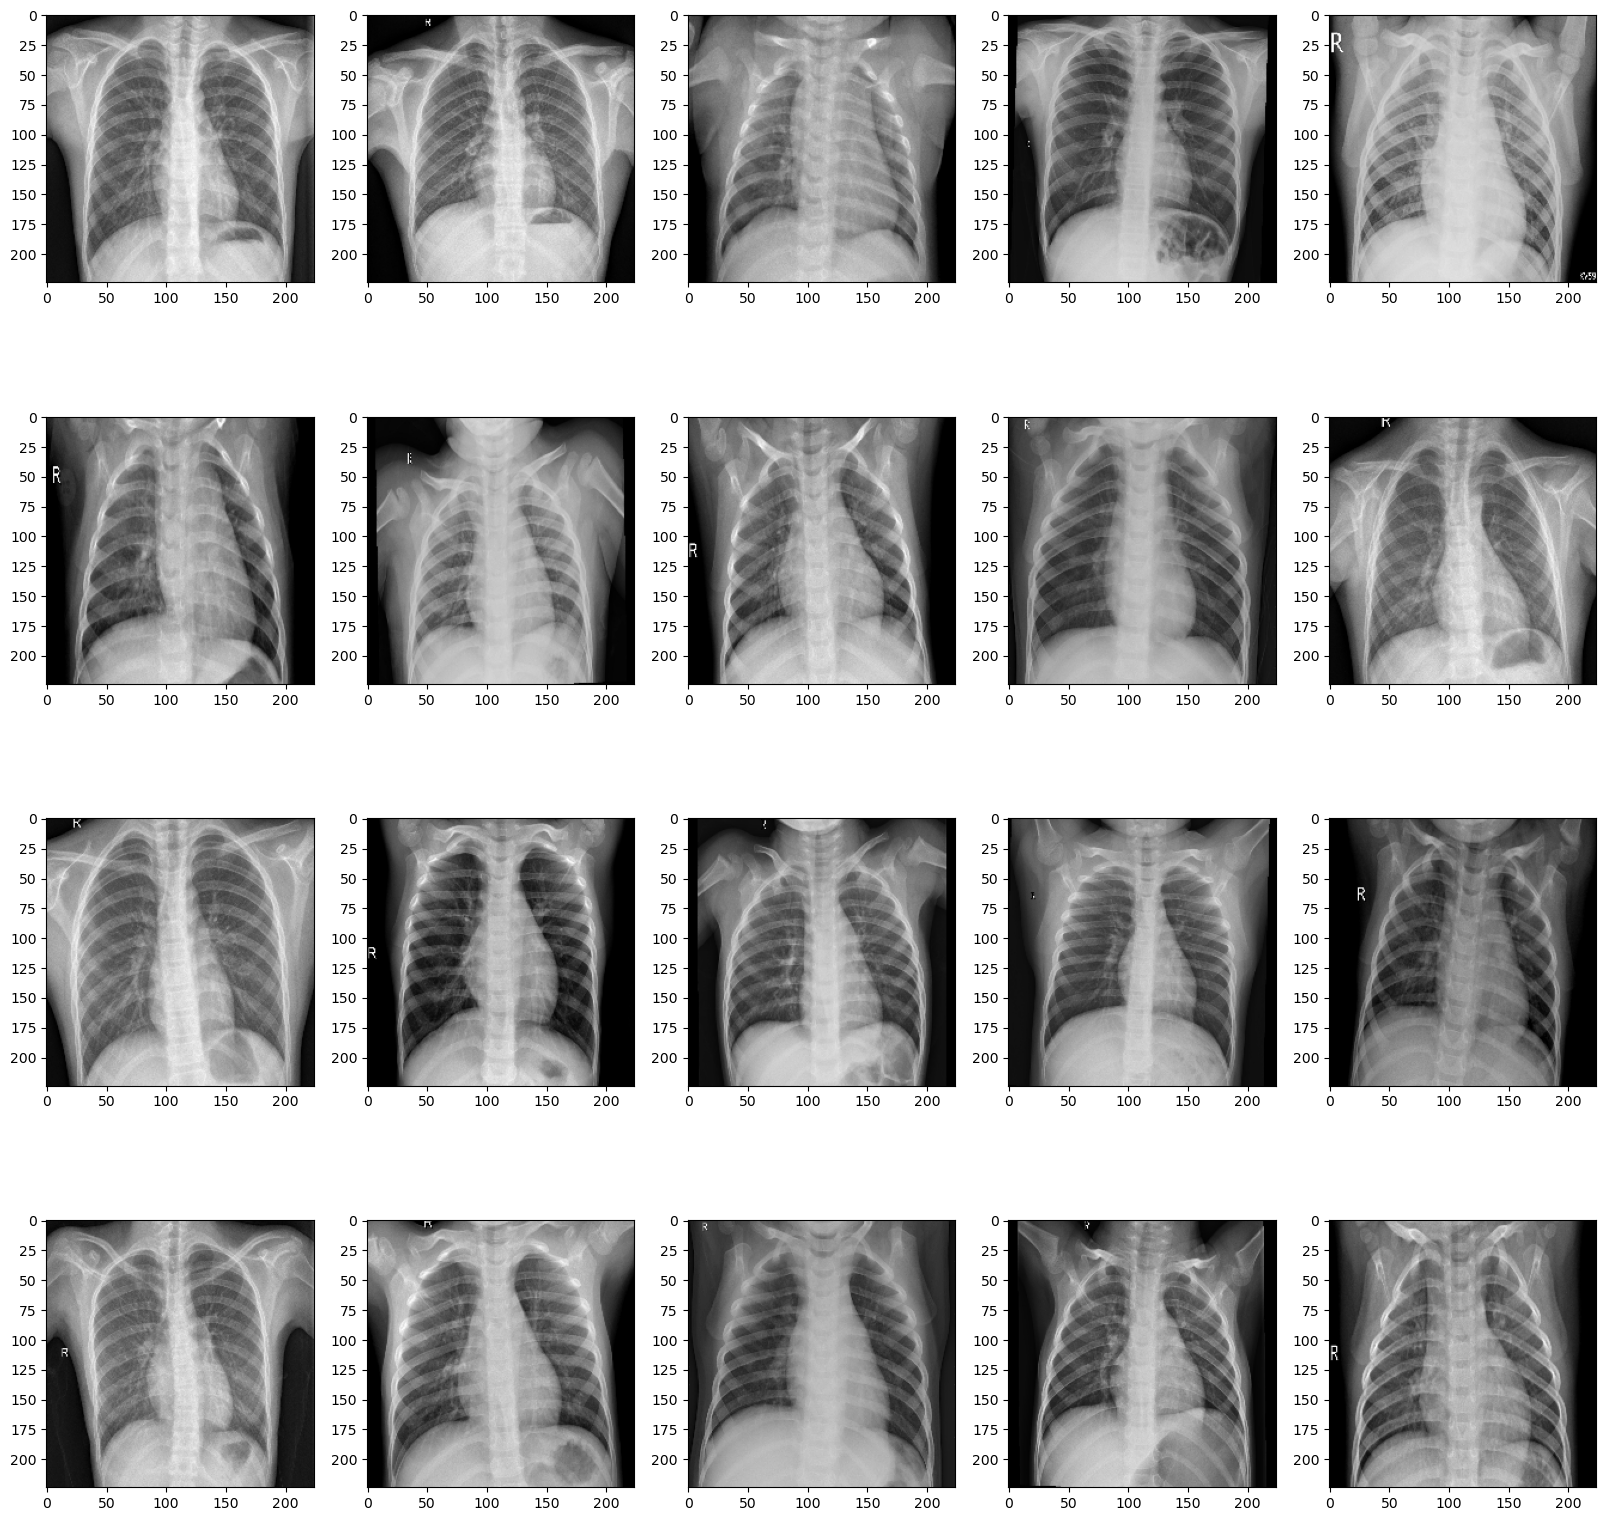

In [48]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(test_dataset[i][0].squeeze()), cmap='gray')

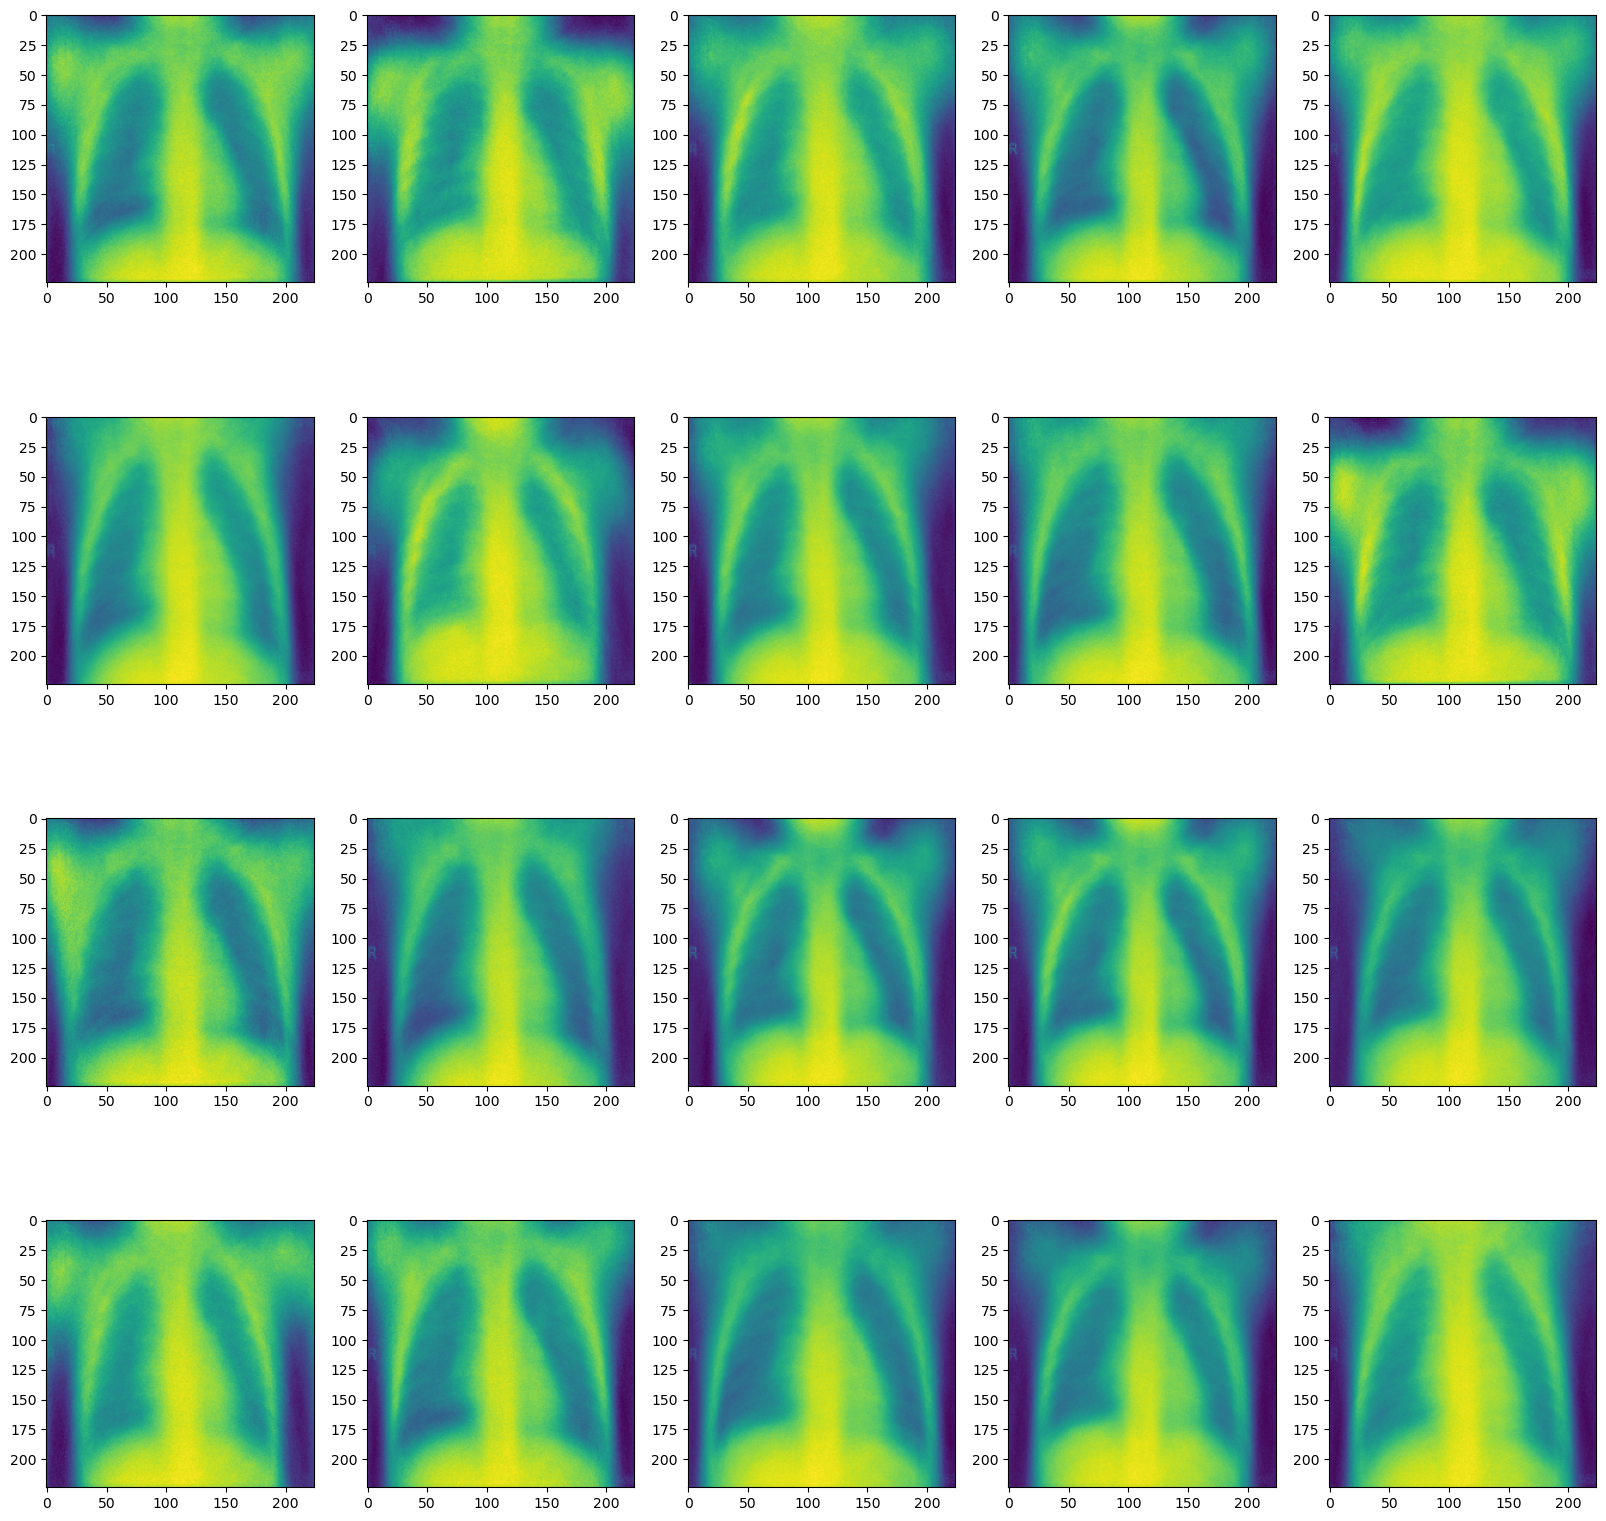

In [63]:
plt.figure(figsize=(20, 20))

for i in range(20):
    img = test_re[i]
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(img).reshape((224, 224)))